In [13]:
import numpy as np
from tqdm import tnrange
import matplotlib.pyplot as plt

import sys
sys.path.insert(0,"../")
import data_generator as gen
import TensorNetwork as tn

from torch.utils.data import DataLoader, Dataset, TensorDataset, SubsetRandomSampler

In [14]:
from importlib import reload

In [15]:
class NumpyDataset(Dataset):
    """
    Add description
    """
    
    def __init__(self, data, label):
        self.data = data
        self.label = label
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        return (self.data[index], self.label[index])

In [16]:
def prepare_dataset(data, label, train_perc, val_perc, train_batch_size, val_batch_size, test_batch_size):
    """
    Add description
    """
    
    def psi(x):
        x = np.array((np.sin(np.pi*x/2),np.cos(np.pi*x/2)))
        return np.transpose(x, [1,2,0])


    # flatten images
    x = data.reshape(len(data),-1)
    # embedd them
    x = psi(x)
    
    # training/test splitting
    m = int(len(x)*train_perc)
    x_train= x[:m]
    y_train = label[:m]
    x_test =  x[m:]
    y_test = label[m:]
    
    # define custom NumpyDatasets
    train_set = NumpyDataset(x_train, y_train)
    test_set =  NumpyDataset(x_test, y_test)
   
    train_len = int(m*(1-val_perc))
    train_sampler = SubsetRandomSampler(np.arange(train_len))
    val_sampler = SubsetRandomSampler(np.arange(train_len,m))

    train_loader = DataLoader(train_set, train_batch_size, sampler=train_sampler, drop_last=True, collate_fn=lambda x: x)
    val_loader = DataLoader(train_set, val_batch_size, sampler=val_sampler, drop_last=True, collate_fn=lambda x: x)
    test_loader = DataLoader(test_set, test_batch_size, drop_last=False, collate_fn=lambda x: x)

    return train_loader, val_loader, test_loader

## Example of training

In [47]:
n_samples = 5000
linear_dim = 14
M = 20
B = 32

In [53]:
(data, label) = gen.create_dataset(n_samples, linear_dim=linear_dim, sigma=0.2)
batch_size = {'train_batch_size':B, 'val_batch_size':128, 'test_batch_size':128}
train_loader, val_loader, test_loader = prepare_dataset(data, label, 0.8, 0.2, **batch_size)

In [54]:
reload(tn)

<module 'TensorNetwork' from '/home/francesco/UNIPD/Information_Theory/TensorNetworkForML/TensorNetwork/TensorNetwork.py'>

In [55]:
calibration_batch = next(iter(train_loader))
x_calibration = np.array([calibration_batch[i][0] for i in range(len(calibration_batch))])

In [57]:
N = linear_dim**2
net = tn.Network(N=N, M=M, L=2, normalize=True, calibration_X=x_calibration)

Normalizing weights...
Scaling factor: 12.80
(32, 196, 2)
f_max for random input of 32 samples :  5.442124936715372e-10
F2:  0.8968782926113396
Sum of all elements of all As (after init):  6878.355616689671
f_max for random input of 32 samples (after):  1.0000000000000016


In [58]:
f = net.forward(x_calibration)
print(f.elem)

[[0.52594112 0.31949251 0.17631667 0.16026242 0.15371059 0.25920039
  0.36813124 0.10097309 0.15001716 0.19104487 0.66661441 0.04460975
  0.15266777 0.23626935 0.17200058 0.05339378 0.75180778 0.11090527
  0.16773258 0.50599904 0.56505869 0.16918613 0.07927358 0.0908635
  0.15950134 0.096605   0.62605192 0.10068467 0.48199532 1.
  0.31028337 0.32326158]
 [0.50664521 0.32169029 0.17098757 0.15437501 0.1546114  0.26145547
  0.37107765 0.09734777 0.14976592 0.19345229 0.64141353 0.04461563
  0.15414347 0.2269472  0.17346364 0.05158346 0.72678062 0.10727644
  0.16727555 0.50947846 0.56662513 0.16259426 0.07633887 0.09115195
  0.1603377  0.0962459  0.6059402  0.0979532  0.48800336 0.96061951
  0.30011385 0.3121011 ]]


In [34]:
train_acc, val_acc = net.train(train_loader, val_loader, lr = 0.01, n_epochs = 10, print_freq=100)

27.60298352711727
13.378610747770336
12.731484714098894
12.572135118992819
12.849278569672824
13.425322499845304
12.361997256081613
13.810012075478816
13.368150897530251
14.161176045266913
14.60169140267236
13.52669825196112
13.113897349215032
13.545746008512177
12.414170389405825
13.175062899074806
13.41205870439936
13.312304748940635
14.208960857603696
13.40841049459378
11.64356503821319
13.117184980952038
14.097317458040319
14.61043662449717
13.379566314982963
14.93180518275674
14.943456977263544
12.241294144290876
15.137404220584289
14.044905853763339
13.186980159895173
14.019471391456618
11.615029266738201
12.431738556064788
10.087547717293463
10.203062572834995
8.972707015287249
10.888240770092942
10.142146683539636
9.439192295421265
8.891433462068534
11.936324751119706
11.08814110969351
9.761365551601584
9.632978869448143
12.368046715122146
11.332110043123729
10.984310315670097
11.17533107054113
11.361485780556295
12.761478386450658
12.23054566155466
10.223927858741472
11.586137

KeyboardInterrupt: 

In [232]:
data = next(iter(train_loader))
x = np.array([data[i][0] for i in range(len(data))])
y = np.array([data[i][1] for i in range(len(data))])
y

array([1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1,
       1, 1, 0, 0, 0, 1, 0, 1, 1, 1])

In [190]:
f = net.forward(x)
print(f.elem.shape)
y_pred = np.argmax(f.elem, axis=0)
y_pred

(2, 32)


array([1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1,
       1, 0, 1, 0, 1, 0, 1, 0, 0, 0])

In [191]:
net.accuracy(x,y)

1.0

# Time profiling

In [ ]:
import time

## Scaling in the number of samples

In [ ]:
n_samples = [1000*i**2 for i in range(1,9)]
print("Number of samples tried: \n", n_samples)

# keep them fixed
linear_dim = 5
M = 20

In [ ]:
times_n_samples = []
for n in n_samples:
    print("Testing with %d samples..."%n)
    (data, label) = gen.create_dataset(n, sigma=0.7)
    batch_size = {'train_batch_size':16, 'val_batch_size':128, 'test_batch_size':128}
    train_loader, val_loader, test_loader = prepare_dataset(data, label, 0.8, 0.2, **batch_size)
    
    # independent from the number of samples
    net = tn.Network(N=linear_dim**2, M=M, L=2)
    
    start = time.time()
    train_acc, val_acc = net.train(train_loader, val_loader, lr = 0.5, n_epochs = 1, print_freq=1)
    dt = time.time() - start
    print("Time for 1 epoch: %.2f s \n"%dt)
    times_n_samples.append(dt)

In [ ]:
plt.figure(figsize=(8,6))
plt.plot(n_samples, times_n_samples, '-o', label='M = %d \nlinear dim = %d'%(M,linear_dim))
plt.xlabel("Number of samples", fontsize=16)
plt.ylabel("Time for one epoch [s]", fontsize=16)
plt.title(r"Training time vs $n_{samples}$", fontsize=16)
plt.legend(fontsize=13)
plt.show()

## Scaling in the number of pixels

In [ ]:
linear_dims = np.arange(4,29,4)
print("Linear dimensions tested: \n", linear_dims)

# keep them fixed
n_samples = 1000
M = 20

In [ ]:
times_linear_dims = []
for linear_dim in linear_dims:
    print("Testing with %d x %d images..."%(linear_dim,linear_dim))
    (data, label) = gen.create_dataset(n_samples, sigma=0.7, linear_dim = linear_dim)
    batch_size = {'train_batch_size':16, 'val_batch_size':128, 'test_batch_size':128}
    train_loader, val_loader, test_loader = prepare_dataset(data, label, 0.8, 0.2, **batch_size)
    
    # independent from the number of samples
    net = tn.Network(N=linear_dim**2, M=M, L=2)
    
    start = time.time()
    train_acc, val_acc = net.train(train_loader, val_loader, lr = 0.5, n_epochs = 1, print_freq=1)
    dt = time.time() - start
    print("Time for 1 epoch: %.2f s \n"%dt)
    times_linear_dims.append(dt)

In [ ]:
plt.figure(figsize=(8,6))
plt.plot(linear_dims**2, times_linear_dims, '-o', label='M = %d \nnum samples = %d'%(M,n_samples))
plt.xlabel("Number of pixels", fontsize=16)
plt.ylabel("Time for one epoch [s]", fontsize=16)
plt.title(r"Training time vs $n_{pixels}$", fontsize=16)
plt.legend(fontsize=13)
plt.show()

## Scaling in the bond dimension

In [ ]:
Ms = [10*i for i in range(1,11)]
print("Bond dimensions tested: \n", Ms)

# keep them fixed
n_samples = 1000
linear_dim = 5

In [ ]:
times_bond_dims = []
for M in Ms:
    print("Testing with bond dimension %d..."%M)
    (data, label) = gen.create_dataset(n_samples, sigma=0.7)
    batch_size = {'train_batch_size':16, 'val_batch_size':128, 'test_batch_size':128}
    train_loader, val_loader, test_loader = prepare_dataset(data, label, 0.8, 0.2, **batch_size)
    
    # independent from the number of samples
    net = tn.Network(N=linear_dim**2, M=M, L=2)
    
    start = time.time()
    train_acc, val_acc = net.train(train_loader, val_loader, lr = 0.5, n_epochs = 1, print_freq=1)
    dt = time.time() - start
    print("Time for 1 epoch: %.2f s \n"%dt)
    times_bond_dims.append(dt)

In [ ]:
plt.figure(figsize=(8,6))
plt.plot(Ms, times_bond_dims, '-o', label='linear dim = %d \nnum samples = %d'%(linear_dim,n_samples))
plt.xlabel("Bond dimension", fontsize=16)
plt.ylabel("Time for one epoch [s]", fontsize=16)
plt.title("Training time vs bond dimension", fontsize=16)
plt.legend(fontsize=13)
plt.show()

## Weight initialization

**Objective:** study what is the dependence in the output magnitude of the various dimensions so that we can choose how to normalize the matrices A during initialization.

**Parameters:**
* Number of pixels N
* Bond dimension M
* Batch size B
* Embedding dimension D (fixed to 2)

Only the first 3 will be inquired.

**Methodology:** Use random input in [0,1] and random initialization in [0,1] for different dimensions and look at the absolute value of the output (take the output among the L with the highest absolute value).

In [ ]:
from importlib import reload
reload(tn)

### Dependence on the number of pixels N

In [ ]:
linear_dims = np.arange(4,16)
print("Linear dimensions tested: \n", linear_dims)

# keep them fixed
n_samples = 1000
M = 20

In [ ]:
magnitude_linear_dims = []
for linear_dim in linear_dims:
    print("Testing with %d x %d images..."%(linear_dim,linear_dim))
    (data, label) = gen.create_dataset(n_samples, sigma=0.7, linear_dim = linear_dim)
    batch_size = {'train_batch_size':16, 'val_batch_size':128, 'test_batch_size':128}
    train_loader, val_loader, test_loader = prepare_dataset(data, label, 0.8, 0.2, **batch_size)
    
    # independent from the number of samples
    net = tn.Network(N=linear_dim**2, M=M, L=2)
    
    batch = next(iter(train_loader))
    X = np.array([batch[i][0] for i in range(len(batch))])
    f = net.forward(X)
    f_max = np.abs(f.elem).max()
    magnitude_linear_dims.append(f_max)

In [ ]:
from sklearn.linear_model import LinearRegression

In [ ]:
magnitude_linear_dims

In [ ]:
Ns = linear_dims**2
y = np.log10(magnitude_linear_dims)
X = Ns.reshape(-1,1)
reg = LinearRegression().fit(X, y)
plt.figure(figsize=(8,6))
plt.plot(Ns, y, label = 'data')
plt.plot(Ns, reg.predict(X), label = 'slope = %.2f'%reg.coef_)
plt.ylabel(r'$log_{10}(f_{max})$', fontsize = 16)
plt.xlabel('Number of pixels N', fontsize = 16)
plt.legend(fontsize=13)
plt.show()

As we can see the dependence on N is exponential, meaning that we can have an exponential suppression (or divergence) if the network is not accurately initialized.

### Isolating dependence C(N)

In [ ]:
y_scaled = y - Ns*np.log10(M)
X = Ns.reshape(-1,1)
reg_C = LinearRegression().fit(X, y_scaled)
plt.figure(figsize=(8,6))
plt.plot(Ns, y_scaled, label = 'data')
plt.plot(Ns, reg_C.predict(X), label = 'slope = %.2f'%reg_C.coef_)
plt.ylabel(r'$log_{10}(f_{max})$', fontsize = 16)
plt.xlabel('Number of pixels N', fontsize = 16)
plt.legend(fontsize=13)
plt.show()

In [ ]:
1/(10**(-0.18))

### Bond dimension M

In [ ]:
Ms = [5*i for i in range(1,21)]
print("Bond dimensions tested: \n", Ms)

# keep them fixed
n_samples = 1000
linear_dim = 5

In [ ]:
magnitude_bond_dims = []
for M in Ms:
    print("Testing with bond dimension %d..."%M)
    (data, label) = gen.create_dataset(n_samples, sigma=0.7, linear_dim=linear_dim)
    batch_size = {'train_batch_size':16, 'val_batch_size':128, 'test_batch_size':128}
    train_loader, val_loader, test_loader = prepare_dataset(data, label, 0.8, 0.2, **batch_size)
    
    # independent from the number of samples
    net = tn.Network(N=linear_dim**2, M=M, L=2)
    
    batch = next(iter(train_loader))
    X = np.array([batch[i][0] for i in range(len(batch))])
    f = net.forward(X)
    f_max = np.abs(f.elem).max()
    magnitude_bond_dims.append(f_max)

In [ ]:
y = np.log10(magnitude_bond_dims)
X = np.log10(np.array(Ms)).reshape(-1,1)
reg_M = LinearRegression().fit(X, y)
plt.figure(figsize=(8,6))
plt.plot(X, y, label = 'data')
plt.plot(X, reg_M.predict(X), label = 'slope = %.3f'%reg_M.coef_)
plt.ylabel(r'$log_{10}(f_{max})$', fontsize = 16)
plt.xlabel(r'Bond dimension $log_{10}(M)$', fontsize = 16)
plt.legend(fontsize=13)
plt.show()

In [ ]:
print(10**reg_M.intercept_)

The output magnitude has a power law dependence on the bond dimension. Notice how the slope is equal to N.
This makes sense since we already know that f is exponential in N. Now we also can approximate the scaling of the f as:
$$f \approx C(N)*M^N$$

### Batch dimension B

In [ ]:
M = 20
n_samples = 1000
linear_dim = 5

train_batch_sizes = np.array([2**i for i in range(1,10)])

In [ ]:
magnitude_batch_size = []
for B in train_batch_sizes:
    (data, label) = gen.create_dataset(n_samples, sigma=0.7, linear_dim = linear_dim)
    batch_size = {'train_batch_size': int(B), 'val_batch_size':128, 'test_batch_size':128}
    train_loader, val_loader, test_loader = prepare_dataset(data, label, 0.8, 0.2, **batch_size)
    
    # independent from the number of samples
    net = tn.Network(N=linear_dim**2, M=M, L=2)
    
    batch = next(iter(train_loader))
    X = np.array([batch[i][0] for i in range(len(batch))])
    f = net.forward(X)
    f_max = np.abs(f.elem).max()
    magnitude_batch_size.append(f_max)

In [ ]:
plt.figure(figsize=(8,6))
plt.plot(train_batch_sizes, magnitude_batch_size, label = 'data')
plt.ylabel(r'$f_{max}$', fontsize = 16)
plt.xlabel('Batch size B', fontsize = 16)
plt.legend(fontsize=13)
plt.show()

No clear dependence emerges on the batch size.

### Conclusion on initialization

The simplest and most reliable initialization is the one that takes into account the number of pixels given as input and disregards all the rest. However remains the problem of choosing the factor with which the weights should be divided. To find an exact factor a priori is not immediate and is also a risky procedure, hence it's better to devise an empirical method to do so.



In [ ]:
linear_dim = 5
n_samples = 1000
M = 10

In [ ]:
reload(tn)

In [ ]:
Cs = np.arange(1,21)
(data, label) = gen.create_dataset(n_samples, sigma=0.7, linear_dim = linear_dim)
batch_size = {'train_batch_size':16, 'val_batch_size':128, 'test_batch_size':128}
train_loader, val_loader, test_loader = prepare_dataset(data, label, 0.8, 0.2, **batch_size)
batch = next(iter(train_loader))
X = np.array([batch[i][0] for i in range(len(batch))])

magnitude_C = []
for C in Cs:
    
    net = tn.Network(N=linear_dim**2, M=M, L=2, normalize=False)
    
    for i in range(net.N):
        net.As[i].elem *= C
    
    f = net.forward(X)
    f_max = np.abs(f.elem).max()
    print('f_max: ', f_max)
    magnitude_C.append(f_max)

In [ ]:
plt.figure(figsize=(8,6))
X = np.log10(Cs).reshape(-1,1)
y = np.log10(np.array(magnitude_C))
y = y/y[0]
reg_scale = LinearRegression().fit(X, y)
plt.plot(X, y, label='data')
plt.plot(X, reg_scale.predict(X), label = 'slope = %.2f\nintercept = %.2f'%(reg_scale.coef_,reg_scale.intercept_))
plt.ylabel(r'$log_{10}(f_{max})$', fontsize = 16)
plt.xlabel(r'Scaling factor $log_{10}(C)$', fontsize = 16)
plt.legend(fontsize=13)
plt.show()

In [ ]:
Ms = np.array([5*i for i in range(1,21)])
Cs = np.arange(1,21)
(data, label) = gen.create_dataset(n_samples, sigma=0.7, linear_dim = linear_dim)
batch_size = {'train_batch_size':16, 'val_batch_size':128, 'test_batch_size':128}
train_loader, val_loader, test_loader = prepare_dataset(data, label, 0.8, 0.2, **batch_size)
batch = next(iter(train_loader))
X = np.array([batch[i][0] for i in range(len(batch))])

magnitude_C_M = []
for M in Ms:
    magnitude_C = []
    for C in Cs:

        net = tn.Network(N=linear_dim**2, M=M, L=2, normalize=False)

        for i in range(net.N):
            net.As[i].elem *= C

        f = net.forward(X)
        f_max = np.abs(f.elem).max()
        magnitude_C.append(f_max)
        
    magnitude_C = np.array(magnitude_C)
    magnitude_C_M.append(magnitude_C)
    
magnitude_C_M = np.array(magnitude_C_M)

In [ ]:
magnitude_C_M.shape

In [ ]:
alphas = []
for i,M in enumerate(Ms):
    X = np.log10(Cs).reshape(-1,1)
    y = np.log10(np.array(magnitude_C_M[i,:]))
    y = y/y[0]
    reg = LinearRegression().fit(X, y)
    alphas.append(reg.coef_)
alphas = np.array(alphas)

In [ ]:
plt.figure(figsize=(8,6))
plt.plot(Ms, alphas)
plt.xlabel('Bond dimension M', fontsize=16)
plt.ylabel(r'$\alpha$ coefficient', fontsize=16)
plt.show()

In [ ]:
reload(tn)

In [ ]:
linear_dims = np.arange(4,29,4)
print("Linear dimensions tested: \n", linear_dims)

# keep them fixed
n_samples = 1000
M = 20

In [ ]:
magnitude_linear_dims = []
for linear_dim in linear_dims:
    print("Testing with %d x %d images..."%(linear_dim,linear_dim))
    (data, label) = gen.create_dataset(n_samples, sigma=0.7, linear_dim = linear_dim)
    batch_size = {'train_batch_size':16, 'val_batch_size':128, 'test_batch_size':128}
    train_loader, val_loader, test_loader = prepare_dataset(data, label, 0.8, 0.2, **batch_size)
    
    # independent from the number of samples
    net = tn.Network(N=linear_dim**2, M=M, L=2, normalize=True)
    
    batch = next(iter(train_loader))
    X = np.array([batch[i][0] for i in range(len(batch))])
    f = net.forward(X)
    f_max = np.abs(f.elem).max()
    magnitude_linear_dims.append(f_max)

In [ ]:
u = np.random.random(10000)
x = np.cos(np.pi/2*u)
x.mean()

In [ ]:
magnitude_linear_dims

In [ ]:
Ns = linear_dims**2
y = np.log10(magnitude_linear_dims)
X = Ns.reshape(-1,1)
reg = LinearRegression().fit(X, y)
plt.figure(figsize=(8,6))
plt.plot(Ns, y, label = 'data')
plt.plot(Ns, reg.predict(X), label = 'slope = %.2f'%reg.coef_)
plt.ylabel(r'$log_{10}(f_{max})$', fontsize = 16)
plt.xlabel('Number of pixels N', fontsize = 16)
plt.legend(fontsize=13)
plt.show()

### Gradient clipping
**Idea**: 

# MNIST dataset

In [17]:
import skimage.measure

def pooling(X):
    X = skimage.measure.block_reduce(X, (1,2,2), np.max)
    return X

In [18]:
MNIST_data = gen.get_MNIST_dataset(data_root_dir = './datasets', download=False)
train_data, train_labels, test_data, test_labels = MNIST_data
data = np.concatenate((train_data,test_data))
data = pooling(data)
labels = np.concatenate((train_labels,test_labels))
batch_size = {'train_batch_size':32, 'val_batch_size':128, 'test_batch_size':128}
train_loader, val_loader, test_loader = prepare_dataset(data, labels, 6/7, 0.2, **batch_size)

In [19]:
mask1 = (labels == 0) 
mask2 = (labels == 1)
mask = mask1 + mask2

In [20]:
labels01 = labels[mask]
data01 = data[mask]
batch_size = {'train_batch_size':128, 'val_batch_size':128, 'test_batch_size':128}
train_loader, val_loader, test_loader = prepare_dataset(data01, labels01, 6/7, 0.2, **batch_size)

In [21]:
reload(tn)

<module 'TensorNetwork' (namespace)>

In [22]:
calibration_batch = next(iter(train_loader))
x_calibration = np.array([calibration_batch[i][0] for i in range(len(calibration_batch))])

In [23]:
net = tn.Network(N=196, M=20, L=2, normalize=True,calibration_X=x_calibration) #, sigma=0.23)

AttributeError: module 'TensorNetwork' has no attribute 'Network'

In [ ]:
train_acc, val_acc = net.train(train_loader, val_loader, lr = 0.01, n_epochs = 10, print_freq=100)

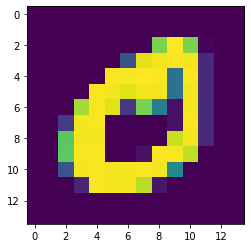

0

In [143]:
n = 5
plt.imshow(data01[n])
plt.show()
labels01[n]